# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 24 kB/s 
     |████████████████████████████████| 1.3 MB 25.4 MB/s 
     |████████████████████████████████| 463 kB 68.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220

If you do not have a GPU, uncomment and run the next commands.


In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [4]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt
from sklearn import metrics

In [5]:
tf.__version__

'2.7.0'

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
%cd drive/MyDrive/ops_sat/the_opssat_case_starter_kit

/content/drive/MyDrive/ops_sat/the_opssat_case_starter_kit


In [8]:
from efficientnet_lite import EfficientNetLiteB0

# 2. Utility Functions

You can use this function to load your training data.

In [9]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [10]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [11]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image].numpy().astype(int))
    
    print('Class: {}'.format(class_mapping[labels[image].numpy()]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
        
    plt.show()    

In [12]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [13]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [ ]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [15]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [16]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [17]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [18]:
y_train.shape

TensorShape([80])

In [19]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

### Train val split

In [20]:
val_indices = [0,
               1,
               0 + 10,
               1 + 10,
               0 + 2 * 10,
               1 + 2 * 10,
               0 + 3 * 10,
               1 + 3 * 10,
               0 + 4 * 10,
               1 + 4 * 10,
               0 + 5 * 10,
               1 + 5 * 10,
               0 + 6 * 10,
               1 + 6 * 10,
               0 + 7 * 10,
               1 + 7 * 10]
val_indices

[0, 1, 10, 11, 20, 21, 30, 31, 40, 41, 50, 51, 60, 61, 70, 71]

In [21]:
x_val = tf.convert_to_tensor(x_train.numpy()[val_indices, :])
y_val = tf.convert_to_tensor(y_train.numpy()[val_indices], dtype=np.int32)
print(x_val.shape, y_val.shape)

(16, 200, 200, 3) (16,)


In [22]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_val == i)))

Class: 0; Occurrences: 2
Class: 1; Occurrences: 2
Class: 2; Occurrences: 2
Class: 3; Occurrences: 2
Class: 4; Occurrences: 2
Class: 5; Occurrences: 2
Class: 6; Occurrences: 2
Class: 7; Occurrences: 2


Class: Mountain


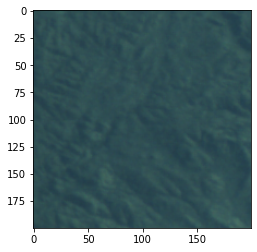

In [23]:
visualize_image(x_val, y_val, 5)

In [24]:
x_train = tf.convert_to_tensor(np.delete(x_train.numpy(), val_indices, axis=0))
y_train = tf.convert_to_tensor(np.delete(y_train.numpy(), val_indices, axis=0), dtype=np.int32)
print(x_train.shape, y_train.shape)

(64, 200, 200, 3) (64,)


In [25]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_train == i)))

Class: 0; Occurrences: 8
Class: 1; Occurrences: 8
Class: 2; Occurrences: 8
Class: 3; Occurrences: 8
Class: 4; Occurrences: 8
Class: 5; Occurrences: 8
Class: 6; Occurrences: 8
Class: 7; Occurrences: 8


Class: Agriculture


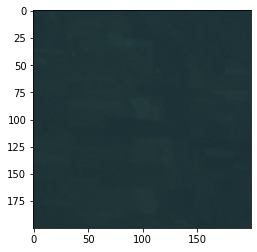

In [26]:
visualize_image(x_train, y_train, 5)

### Augment images

#### Rotate images

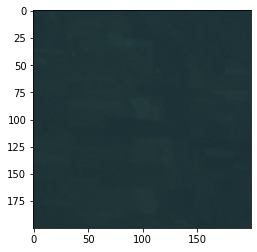

In [27]:
plt.imshow(x_train[5].numpy().astype(int))

90 degrees counterclockwise

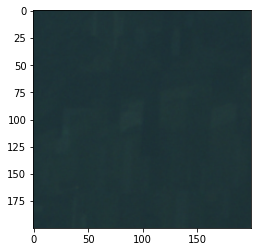

In [28]:
plt.imshow(np.rot90(x_train[5].numpy().astype(int), k=1, axes=(0, 1)))

In [29]:
x_train_rot90_ccw = np.rot90(x_train.numpy().astype(int), axes=(1,2))

In [30]:
x_train_rot90_ccw.shape

(64, 200, 200, 3)

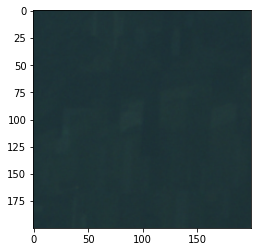

In [31]:
plt.imshow(x_train_rot90_ccw[5])

In [32]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train.numpy(), x_train_rot90_ccw]))
x_train_augmented.shape

TensorShape([128, 200, 200, 3])

In [33]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([128])

180 degrees

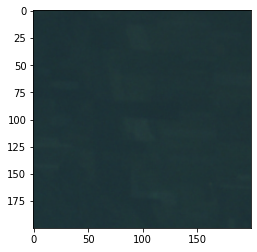

In [34]:
plt.imshow(np.rot90(np.rot90(x_train[5].numpy().astype(int), k=1, axes=(0, 1)), k=1, axes=(0, 1)))

In [35]:
x_train_rot180 = np.rot90(np.rot90(x_train.numpy().astype(int), axes=(1,2)), axes=(1,2))

In [36]:
x_train_rot180.shape

(64, 200, 200, 3)

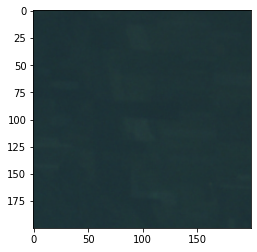

In [37]:
plt.imshow(x_train_rot180[5])

In [38]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot180]))
x_train_augmented.shape

TensorShape([192, 200, 200, 3])

In [39]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([192])

90 degrees clockwise

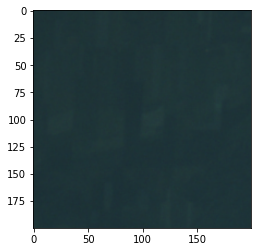

In [40]:
plt.imshow(np.rot90(x_train[5].numpy().astype(int), k=-1, axes=(0, 1)))

In [41]:
x_train_rot90_cw = np.rot90(x_train.numpy().astype(int), axes=(2,1))

In [42]:
x_train_rot90_cw.shape

(64, 200, 200, 3)

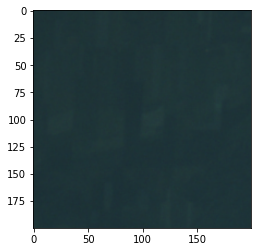

In [43]:
plt.imshow(x_train_rot90_cw[5])

In [44]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot90_cw]))
x_train_augmented.shape

TensorShape([256, 200, 200, 3])

In [45]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([256])

#### Flip images

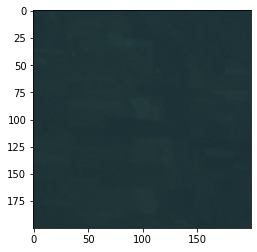

In [46]:
plt.imshow(x_train[5].numpy().astype(int))

Up/down

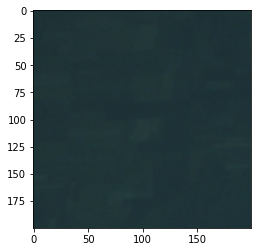

In [47]:
plt.imshow(np.flipud(x_train[5].numpy().astype(int)))

In [48]:
x_train_flipud = np.array([np.flipud(i.numpy().astype(int)) for i in x_train])

In [49]:
x_train_flipud.shape

(64, 200, 200, 3)

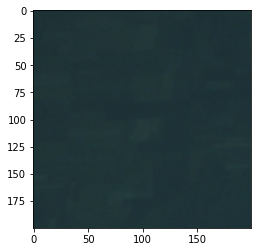

In [50]:
plt.imshow(x_train_flipud[5])

In [51]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_flipud]))
x_train_augmented.shape

TensorShape([320, 200, 200, 3])

In [52]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([320])

Left/right

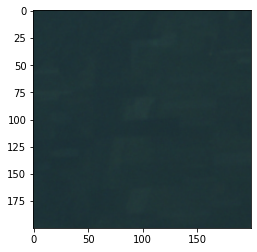

In [53]:
plt.imshow(np.fliplr(x_train[5].numpy().astype(int)))

In [54]:
x_train_fliplr = np.array([np.fliplr(i.numpy().astype(int)) for i in x_train])

In [55]:
x_train_fliplr.shape

(64, 200, 200, 3)

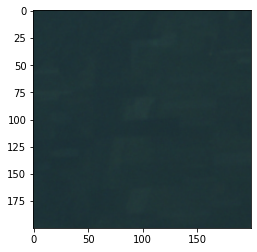

In [56]:
plt.imshow(x_train_fliplr[5])

In [57]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_fliplr]))
x_train_augmented.shape

TensorShape([384, 200, 200, 3])

In [58]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([384])

#### Flip rotated images up/down

Skip the following variations since these images already exist:

- rot180 ud
- rot90 ccw lr
- rot90 cw lr

90 degrees counterclockwise up/down

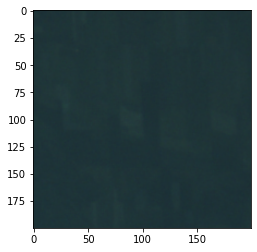

In [59]:
plt.imshow(np.flipud(x_train_rot90_ccw[5]))

In [60]:
x_train_rot90_ccw_flipud = np.array([np.flipud(i) for i in x_train_rot90_ccw])

In [61]:
x_train_rot90_ccw_flipud.shape

(64, 200, 200, 3)

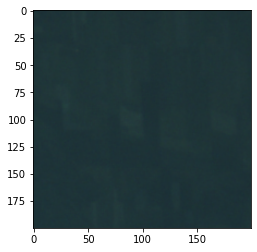

In [62]:
plt.imshow(x_train_rot90_ccw_flipud[5])

In [63]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot90_ccw_flipud]))
x_train_augmented.shape

TensorShape([448, 200, 200, 3])

In [64]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([448])

90 degrees clockwise up/down

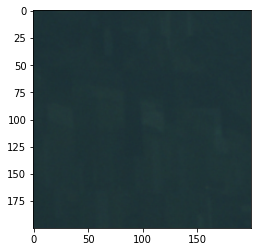

In [65]:
plt.imshow(np.flipud(x_train_rot90_cw[5]))

In [66]:
x_train_rot90_cw_flipud = np.array([np.flipud(i) for i in x_train_rot90_cw])

In [67]:
x_train_rot90_cw_flipud.shape

(64, 200, 200, 3)

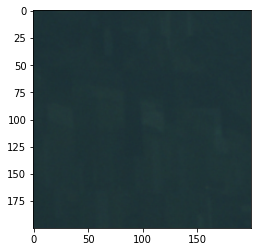

In [68]:
plt.imshow(x_train_rot90_cw_flipud[5])

In [69]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot90_cw_flipud]))
x_train_augmented.shape

TensorShape([512, 200, 200, 3])

In [70]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([512])

#### Add Gaussian noise to images

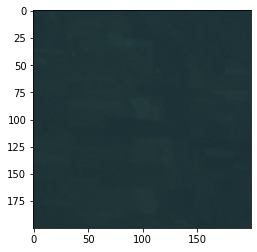

In [71]:
plt.imshow(x_train[5].numpy().astype(int))

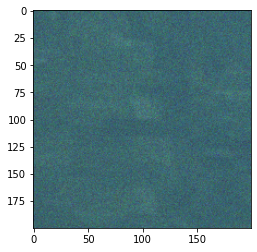

In [72]:
noise = np.random.normal(x_train[5].numpy(), 0.2 * x_train[5].numpy())
noisy_image = np.round(x_train[5].numpy() + noise, 0)
plt.imshow(noisy_image.astype(int))

In [73]:
x_train_noise = np.array([np.round(i + (np.random.normal(i.numpy(), 0.2 * i.numpy())), 0) for i in x_train_augmented])

In [74]:
x_train_noise.shape

(512, 200, 200, 3)

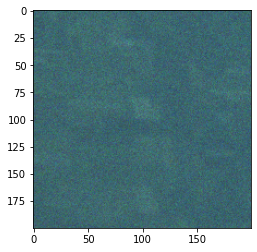

In [75]:
plt.imshow(x_train_noise[5].astype(int))

In [76]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_noise]))
x_train_augmented.shape

TensorShape([1024, 200, 200, 3])

In [77]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train_augmented.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([1024])

# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [110]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [111]:
tf.random.set_seed(42)

In [112]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [113]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train_augmented, y_train_augmented, epochs=55, verbose=1, batch_size=8, callbacks=[callback], validation_data=(x_val, y_val))

Epoch 1/55
128/128 [==============================] - 12s 64ms/step - loss: 2.0148 - sparse_categorical_accuracy: 0.2354 - val_loss: 2.5419 - val_sparse_categorical_accuracy: 0.1875
Epoch 2/55
128/128 [==============================] - 8s 59ms/step - loss: 1.8659 - sparse_categorical_accuracy: 0.2773 - val_loss: 3.1220 - val_sparse_categorical_accuracy: 0.1875
Epoch 3/55
128/128 [==============================] - 7s 58ms/step - loss: 1.8329 - sparse_categorical_accuracy: 0.2832 - val_loss: 2.0682 - val_sparse_categorical_accuracy: 0.1875
Epoch 4/55
128/128 [==============================] - 8s 60ms/step - loss: 1.7301 - sparse_categorical_accuracy: 0.3223 - val_loss: 2.2873 - val_sparse_categorical_accuracy: 0.1250
Epoch 5/55
128/128 [==============================] - 8s 60ms/step - loss: 1.6033 - sparse_categorical_accuracy: 0.3789 - val_loss: 2.3787 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/55
128/128 [==============================] - 7s 58ms/step - loss: 1.4981 - sparse_cat

### Plot loss and accuracy

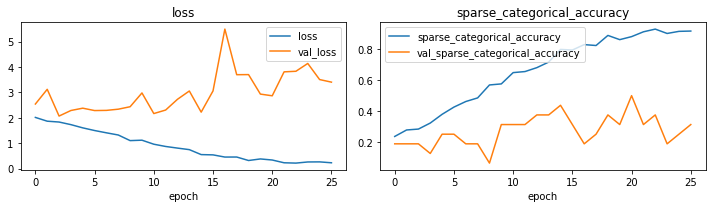

In [114]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [115]:
predictions = evaluate_model(x_train_augmented, y_train_augmented)

Score: 0.1819196428571428


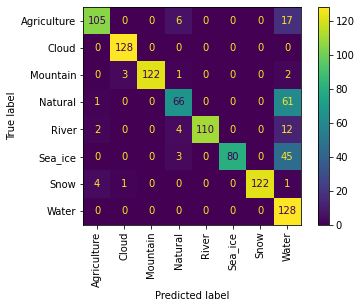

In [116]:
get_confusion_matrix(y_train_augmented, predictions)

Class: Agriculture
Predicted: Agriculture


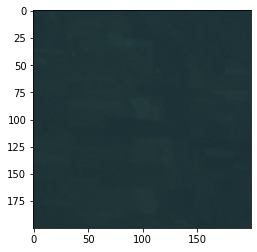

In [118]:
visualize_image(x_train_augmented, y_train_augmented, 5, pred=True, predictions=predictions)

In [119]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train_augmented, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train_augmented, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train_augmented, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train_augmented, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train_augmented, predictions))

Accuracy: 0.841
Precision: 0.841
Recall: 0.841
F1-Score: 0.841
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       128
           1       0.97      1.00      0.98       128
           2       1.00      0.95      0.98       128
           3       0.82      0.52      0.63       128
           4       1.00      0.86      0.92       128
           5       1.00      0.62      0.77       128
           6       1.00      0.95      0.98       128
           7       0.48      1.00      0.65       128

    accuracy                           0.84      1024
   macro avg       0.90      0.84      0.85      1024
weighted avg       0.90      0.84      0.85      1024



### Evaluation on val set

In [120]:
predictions = evaluate_model(x_val, y_val)

Score: 0.7857142857142857


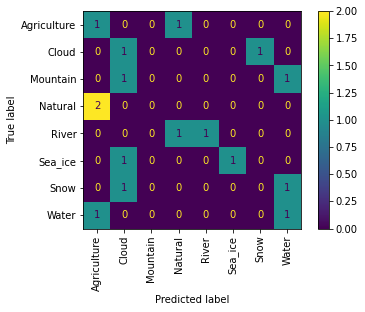

In [121]:
get_confusion_matrix(y_val, predictions)

Class: Mountain
Predicted: Cloud


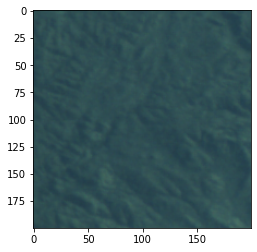

In [122]:
visualize_image(x_val, y_val, 5, pred=True, predictions=predictions)

In [123]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

print(metrics.classification_report(y_val, predictions))

Accuracy: 0.312
Precision: 0.312
Recall: 0.312
F1-Score: 0.312
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.25      0.50      0.33         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       1.00      0.50      0.67         2
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         2
           7       0.33      0.50      0.40         2

    accuracy                           0.31        16
   macro avg       0.35      0.31      0.30        16
weighted avg       0.35      0.31      0.30        16



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [124]:
#Saving model
model.save_weights('v6.h5')

The trained model can be also loaded for further testing. 

In [125]:
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v6.h5')

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same


The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [126]:
#Model shall be compiled before testing.
model.compile()

predictions = evaluate_model(x_train_augmented, y_train_augmented)

Score: 0.1819196428571428


In [127]:
!time python train.py

2022-09-16 21:08:13.968705: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Found 80 files belonging to 8 classes.
2022-09-16 21:08:14.981602: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 38400000 exceeds 10% of free system memory.
2022-09-16 21:08:15.452108: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 153600000 exceeds 10% of free system memory.
2022-09-16 21:08:16.057733: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 230400000 exceeds 10% of free syst